# PowerBALD (Kirsch et al. 2022)

**NOTE: Members of Baal are co-authors on this paper.**


PowerBALD is first introduced in the paper in [Stochastic Batch Acquisition for Deep Active Learning](https://arxiv.org/abs/2106.12059). The idea is simple: instead of selecting the top-K uncertain examples, we will sample from the uncertainty distribution.

Let $U(x | D)$ be the BALD uncertainty of an input $x$ given a dataset $D$. Usually, the next item to label would be $\arg\max_{x \in D_U} \; U(x | D_U)$.

PowerBALD proposes to instead select the next item by sampling from the distribution $U$.

This method has been shown to be as performant as BatchBALD or BADGE while being extremely fast.
<br>

|                                   | BADGE      | BatchBALD    | PowerBALD      |
|-----------------------------------|------------|--------------|----------------|
| Runtime in seconds (10000 inputs) | 82.1 ± 2.5 | 363.6 ± 95.4 | **0.2  ± 0.0** |


We will showcase the strength of PowerBALD on CLINC-151. This is also a very simple tutorial on how to get uncertainty using HuggingFace.


In [1]:
from baal.bayesian.dropout import patch_module
from datasets import load_dataset
from baal.active.dataset.nlp_datasets import active_huggingface_dataset
from baal.transformers_trainer_wrapper import BaalTransformersTrainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load CLINC without OOS as it is a special case.
raw_test_set = load_dataset("clinc_oos", "small")['test']
oos_index = raw_test_set.features['intent'].names.index('oos')
raw_test_set = raw_test_set.filter(lambda u: u['intent'] != oos_index)

# Load pretrained model
pretrained_weights = 'transformersbook/distilbert-base-uncased-distilled-clinc'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=pretrained_weights)

use_cuda = torch.cuda.is_available()

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=pretrained_weights)
model = patch_module(model)
if use_cuda:
    model.cuda()

trainer = BaalTransformersTrainer(model=model)

# Preprocess dataset
active_set = active_huggingface_dataset(raw_test_set, tokenizer, target_key="intent", input_key="text")

Reusing dataset clinc_oos (/home/fred/.cache/huggingface/datasets/clinc_oos/small/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

Parameter 'function'=<function <lambda> at 0x7f8685fc5af0> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/6 [00:00<?, ?ba/s]

In [2]:
from baal.active.heuristics import BALD
from baal.active.heuristics.stochastics import PowerSampling

QUERY_SIZE = 50
prediction = trainer.predict_on_dataset(active_set._dataset, iterations=20)
uncertainty = BALD().get_uncertainties(prediction)
bald_queries = BALD()(prediction)[:QUERY_SIZE]
powerbald_queries = PowerSampling(BALD(), query_size=QUERY_SIZE)(prediction)

[197666-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-18T17:53:51.534414Z [info     ] Start Predict                  dataset=4500


100%|██████████| 563/563 [09:27<00:00,  1.01s/it]


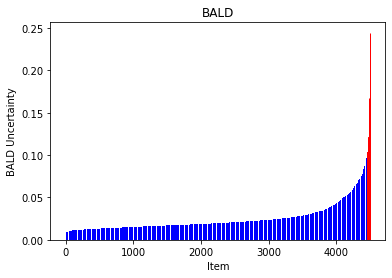

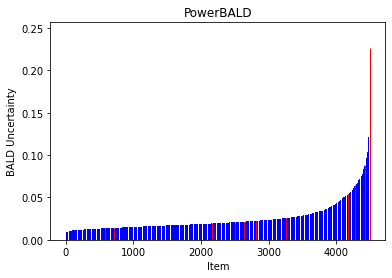

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# If we plot everything, we would get the following.
def plot_uncertainty(uncertainty, queries, title):
    sorted_uncertainty = np.argsort(uncertainty).tolist()
    x = np.arange(len(sorted_uncertainty))
    bars = plt.bar(x, uncertainty[sorted_uncertainty], color='blue')
    for q in queries:
        bars[sorted_uncertainty.index(q)].set_color('red')
    plt.title(title)
    plt.xlabel("Item")
    plt.ylabel("BALD Uncertainty")
    plt.show()
plot_uncertainty(uncertainty, queries=bald_queries, title="BALD")
plot_uncertainty(uncertainty, queries=powerbald_queries, title="PowerBALD")

In the figures above, PowerBALD samples more diversely than BALD while selecting high uncertainty items in priority.


The lack of diversity has been explored in [Tsymbalov et al, 2019](https://arxiv.org/abs/1902.10350) and [BatchBALD](https://arxiv.org/abs/1906.08158).
 In Figure 1 below, high uncertainty points are often highly correlated. As a result, selecting the top-K examples is suboptimal.
<img src="https://i.imgur.com/zqg0Jlx.png" width="500"/>
